# Context
The data was collected from an apartment unit in San Jose for one plus year of one of Kaggle's community members. The collection was done with smart meters and shared by his energy company. This is time-series data by nature and can be used for various time-series Machine Learning experiments.

## Description of Data
The data contains eight attributes.

- TYPE - This is an information column. The value is 'Electric usage' for all the observations.
- DATE - Date of electric consumption. There is no timestamp in this field.
- START TIME - Start time of the consumption.
- END TIME - End time of the consumption
- USAGE - Consumption in kWh
- UNITS - This column denotes measurement unit. It is kWh for all the observations.
- COST - Cost of consumption in $.
- NOTES - Mostly an empty column

# Setting the environment and loading data 

In [1]:
import pandas as pd
import numpy as np
''' Data visualisation'''
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
''' Scikit-Learn'''
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn import set_config

set_config(display='diagram')
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector
from sklearn.metrics import confusion_matrix
''' Imbalanced Classes'''
import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
''' Tensorflow Keras'''
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import Sequential, layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay

Init Plugin
Init Graph Optimizer
Init Kernel


In [2]:
data= pd.read_csv("../IOTTimeSeries/Data/D202.csv", parse_dates=True)
data.head()

,TYPE,DATE,START TIME,END TIME,USAGE,UNITS,COST,NOTES
0,Electric usage,10/22/2016,0:00,0:14,0.01,kWh,$0.00,NaN
1,Electric usage,10/22/2016,0:15,0:29,0.01,kWh,$0.00,NaN
2,Electric usage,10/22/2016,0:30,0:44,0.01,kWh,$0.00,NaN
3,Electric usage,10/22/2016,0:45,0:59,0.01,kWh,$0.00,NaN
4,Electric usage,10/22/2016,1:00,1:14,0.01,kWh,$0.00,NaN


# EDA 

## Data Exploration

In [3]:
#data information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70368 entries, 0 to 70367
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   TYPE        70368 non-null  object 
 1   DATE        70368 non-null  object 
 2   START TIME  70368 non-null  object 
 3   END TIME    70368 non-null  object 
 4   USAGE       70368 non-null  float64
 5   UNITS       70368 non-null  object 
 6   COST        70368 non-null  object 
 7   NOTES       0 non-null      float64
dtypes: float64(2), object(6)
memory usage: 4.3+ MB


We notice columns that we can promptly delete as unnecessary to our analysis, along with Notes columns which holds no information.

For this specific dataset we have no missing values. 

In [4]:
#duplicates

duplicates= data.duplicated()
duplicates.sum()

0

## Data prep

In [5]:
#timestamp column creation 
add_prefix_lambda = lambda start_time: "0"+ start_time if int(start_time.split(":")[0]) < 12 else start_time
data["START TIME"] = data["START TIME"].apply(add_prefix_lambda)

data["timestamp"] = data["DATE"] + " " + data["START TIME"]
data["timestamp"] = pd.to_datetime(data["timestamp"])

In [6]:
data.head()

,TYPE,DATE,START TIME,END TIME,USAGE,UNITS,COST,NOTES,timestamp
0,Electric usage,10/22/2016,00:00,0:14,0.01,kWh,$0.00,NaN,2016-10-22 00:00:00
1,Electric usage,10/22/2016,00:15,0:29,0.01,kWh,$0.00,NaN,2016-10-22 00:15:00
2,Electric usage,10/22/2016,00:30,0:44,0.01,kWh,$0.00,NaN,2016-10-22 00:30:00
3,Electric usage,10/22/2016,00:45,0:59,0.01,kWh,$0.00,NaN,2016-10-22 00:45:00
4,Electric usage,10/22/2016,01:00,1:14,0.01,kWh,$0.00,NaN,2016-10-22 01:00:00


In [7]:
df = data[["timestamp", "USAGE"]]
df.columns = ["timestamp", "usage"]
df.set_index("timestamp")

,usage
timestamp,
2016-10-22 00:00:00,0.01
2016-10-22 00:15:00,0.01
2016-10-22 00:30:00,0.01
2016-10-22 00:45:00,0.01
2016-10-22 01:00:00,0.01
...,...
2018-10-24 22:45:00,0.02
2018-10-24 23:00:00,0.03
2018-10-24 23:15:00,0.03


In [8]:
df.head()

,timestamp,usage
0,2016-10-22 00:00:00,0.01
1,2016-10-22 00:15:00,0.01
2,2016-10-22 00:30:00,0.01
3,2016-10-22 00:45:00,0.01
4,2016-10-22 01:00:00,0.01


In [9]:
#hourly
hourly_usage = df.set_index('timestamp').resample('1h').sum()

# Daily
daily_usage = hourly_usage.resample("1D").sum()

# Monthly
monthly_usage= daily_usage.resample("1M").sum()


In [10]:
monthly_usage.head()

,usage
timestamp,
2016-10-31,85.60
2016-11-30,404.36
2016-12-31,624.52
2017-01-31,742.40
2017-02-28,458.12


## Visualization

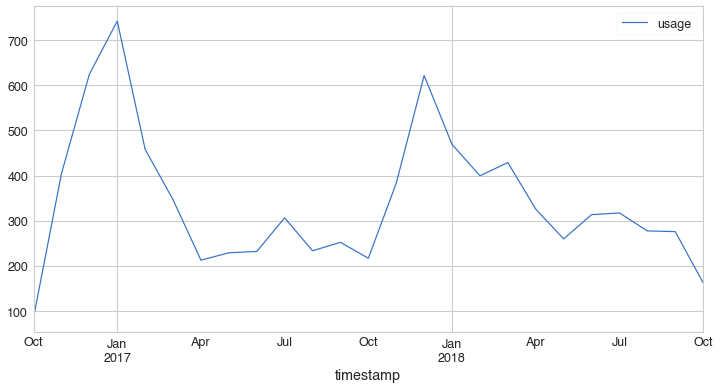

In [11]:
fig, ax = plt.subplots(figsize=(12,6))
monthly_usage.plot(ax=ax)
plt.show()

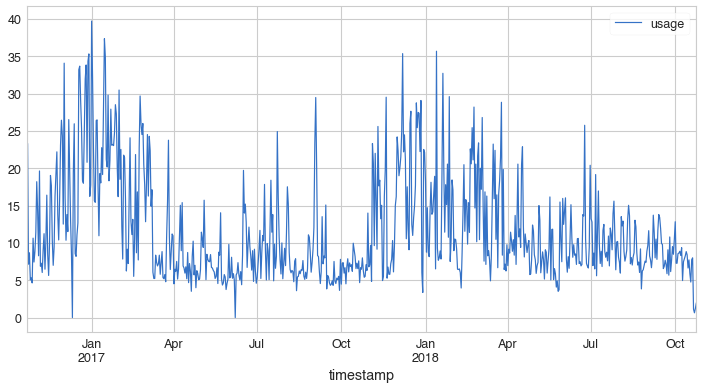

In [12]:
fig, ax = plt.subplots(figsize=(12,6))

daily_usage.plot(ax=ax)
plt.show()

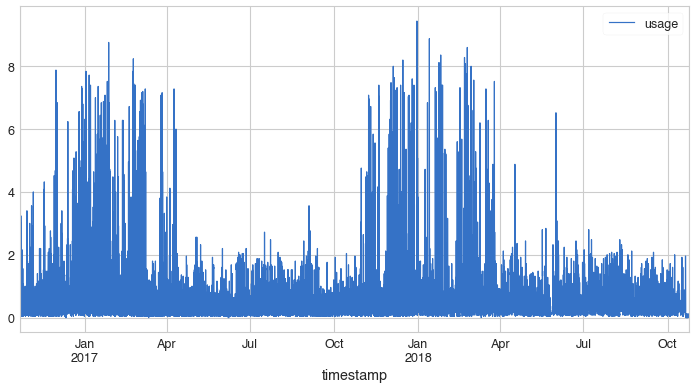

In [13]:
fig, ax = plt.subplots(figsize=(12,6))

hourly_usage.plot(ax=ax)
plt.show()

- From the monthly usage plot, we figure a seasonality of the energy usage time series that occurs by the end of each year marking momentums.
 
- Zooming in the daily usage, the consumption appears unstationary with seasonality that we need to decompose later on. 

Before digging deeper in the forecast, there is a couple of assumptions that we need to confirm: Sationarity of the series. 




# Stationarity 

For this case, I chose to work with the daily series. Let's check and see if it's stationary or not using the adfuller test. 

In [18]:
from statsmodels.tsa.stattools import adfuller
results = adfuller(daily_usage.usage)

# printing results
print('ADF Statistic:', results[0])
print('p-value:', results[1])

ADF Statistic: -2.423278437269911
p-value: 0.13527373635779383


From the adfuller test that captures pretty well the "stationary" trend we note the following results:
- The ADF statistics are  quite negative which hints on stationarity 
- P-value is greater than 0.05 , therefore we cannot reject H0 stating non-stationarity. 

This series is thereof **non-stationary**. Before we start  to differentiate it to make it stationary and ready to forecast, we'll decompose the seasonal attributes first.
    

# Seasonal decomposition 

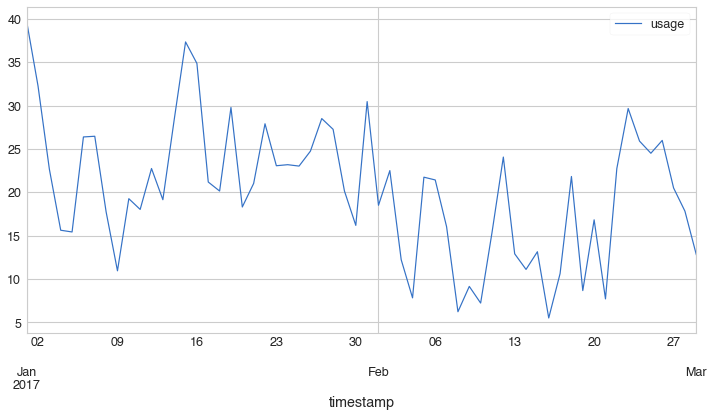

In [26]:
jan_17 = daily_usage.loc["2017-01-01": "2017-03-01"]

fig, ax = plt.subplots(figsize=(12,6))
jan_17.plot(ax=ax)
plt.show()

Since the time series is non-stationary, the ACF plot will be clearer if we detrend it first.

From the plot above of a 2-month stamp, we can see a seasonal period of around 12 days where it hits a higher peak flow. We'll validate our assumption using ACF visually.

In [28]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomp_results= seasonal_decompose(daily_usage.usage, period=12)
type(decomp_results)

statsmodels.tsa.seasonal.DecomposeResult

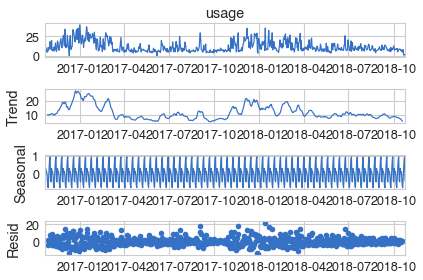

In [29]:
#plot decomposed data 
decomp_results.plot();

Sometimes it can be particularly hard to tell by eye if the series is seasonal or not. This's where ACF comes handy. 
We might need to detrend it first before plotting the ACF.

In [30]:
# detrending the time series 

daily_detrend= daily_usage - daily_usage.rolling(12).mean()
daily_detrend= daily_detrend.dropna()

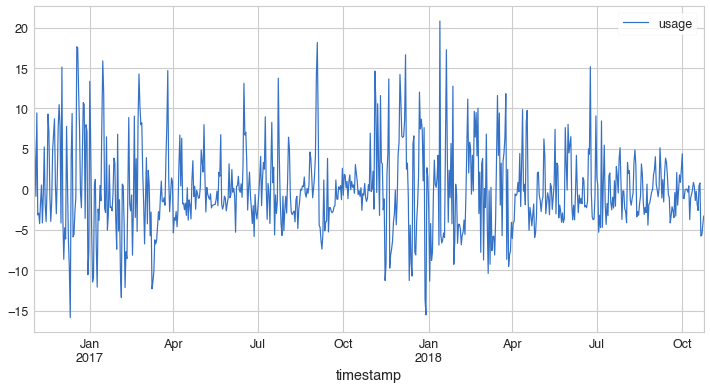

In [31]:
# plotting the detrended time series 
fig, ax = plt.subplots(figsize=(12,6))
daily_detrend.plot(ax=ax)
plt.show()

## Indentifying seasonal data using ACF 

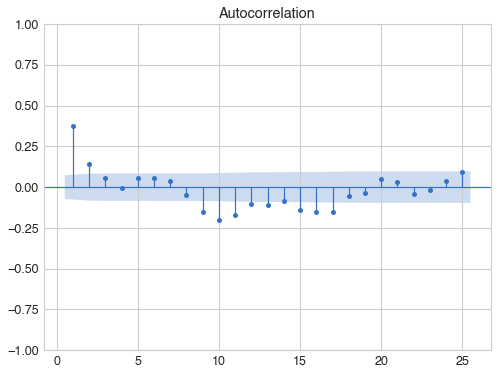

In [34]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, plot_predict

fig, ax = plt.subplots(1,1, figsize=(8,6))
plot_acf(daily_detrend, ax=ax, lags=25, zero=False);

The ACF plot doesn't depict any seasonal trend in our series. We could have seen clear peaks easily identifiable through ACF but **this indicated the non seasonality of the data.**

# Forecasting using ARIMA

## picking the number of differencing order

In [35]:
results = adfuller(daily_usage)

# printing results
print('ADF Statistic:', results[0])
print('p-value:', results[1])

ADF Statistic: -2.423278437269911
p-value: 0.13527373635779383


In [36]:
results_ = adfuller(daily_usage.diff().dropna())

# printing results
print('ADF Statistic:', results_[0])
print('p-value:', results_[1])

ADF Statistic: -10.370895608539842
p-value: 2.2656194053141393e-18


Differecing our data one time seems to fully convert the series into a stationary one. We'll then use d=1 for our model.

## Detemining the orders of p and q 

/Users/oumniasadaouni/.pyenv/versions/3.8.6/envs/pix2pix/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


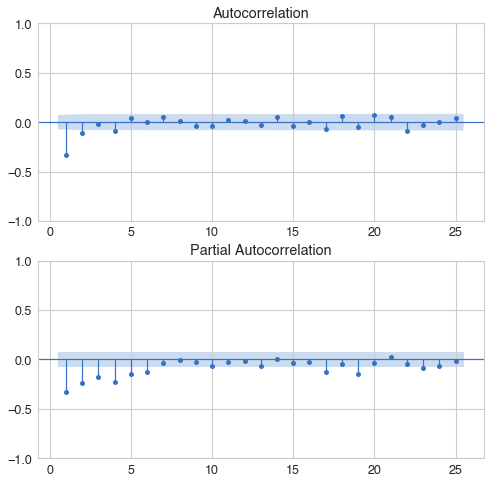

In [39]:
df_= daily_usage.diff().dropna()
fig, (ax1, ax2) = plt.subplots(2, 1, figsize =(8,8))
plot_acf(df_, lags=25, zero=False, ax=ax1)
plot_pacf(df_, lags=25, zero=False, ax=ax2);

By comparing the ACF and PACF plot, the first  lightly cuts off at lag 2 and the second tails off.This result doesn't allow us to choose the number or orders confidently. We'll use another approach depicting the good-fit of the model through AIC and BIC  information criteria

## AIC vs BIC

In [64]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
order_aic_bic=[]
for p in range(4):
    for q in range(4):
        try:
            model = SARIMAX(daily_usage, order=(p,1,q))
            results= model.fit(disp=0)
            print(p, q, results.aic, results.bic)
            order_aic_bic.append((p, q, results.aic, results.bic))
        except:
            print(p, q, None, None)
            order_aic_bic.append((p, q, None, None))

order_df = pd.DataFrame(order_aic_bic, columns =["p", "q", "aic", "bic"])


0 0 4730.245169199424 4734.840949713385
0 1 4550.015997856782 4559.207558884705
0 2 4514.383280992091 4528.170622533975
0 3 4512.257358722632 4530.640480778477
1 0 4646.249059953359 4655.440620981282
1 1 4508.969864106851 4522.757205648734
1 2 4510.876344043916 4529.259466099761
1 3 4511.95614316221 4534.935045732016
2 0 4604.506366004032 4618.293707545916
2 1 4510.880084658695 4529.26320671454
2 2 4512.440610528414 4535.419513098221
2 3 4513.69542072667 4541.270103810438
3 0 4584.459790187441 4602.842912243286
3 1 4512.847551213442 4535.826453783248
3 2 4513.498341368124 4541.073024451892
3 3 4511.3856577051565 4543.556121302886


/Users/oumniasadaouni/.pyenv/versions/3.8.6/envs/pix2pix/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [65]:
#sorting by aic 
order_df.sort_values("aic")

,p,q,aic,bic
5,1,1,4508.969864,4522.757206
6,1,2,4510.876344,4529.259466
9,2,1,4510.880085,4529.263207
15,3,3,4511.385658,4543.556121
7,1,3,4511.956143,4534.935046
3,0,3,4512.257359,4530.640481
10,2,2,4512.440611,4535.419513
13,3,1,4512.847551,4535.826454
14,3,2,4513.498341,4541.073024
11,2,3,4513.695421,4541.270104


In [66]:
#sorting by aic 
order_df.sort_values("bic")

,p,q,aic,bic
5,1,1,4508.969864,4522.757206
2,0,2,4514.383281,4528.170623
6,1,2,4510.876344,4529.259466
9,2,1,4510.880085,4529.263207
3,0,3,4512.257359,4530.640481
7,1,3,4511.956143,4534.935046
10,2,2,4512.440611,4535.419513
13,3,1,4512.847551,4535.826454
14,3,2,4513.498341,4541.073024
11,2,3,4513.695421,4541.270104


Luckily enough, AIC & BIC chose the same model of orders: p=1, q=1 and we have d=1 

## Fitting model

In [67]:
model= SARIMAX(daily_usage, order=(1,1,1))
results = model.fit()
residuals= results.resid

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.09084D+00    |proj g|=  9.79078D-02

At iterate    5    f=  3.07205D+00    |proj g|=  2.33424D-02

At iterate   10    f=  3.07160D+00    |proj g|=  1.65874D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     13      1     0     0   3.220D-06   3.072D+00
  F =   3.0716029086677019     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


## Model Diagnostics

### Residuals 

In [69]:
residuals.mean()

-0.021726946899591898

### MAE

In [70]:
mae = np.mean(np.abs(residuals))
mae

3.8269626402269914

### diagnostics plot

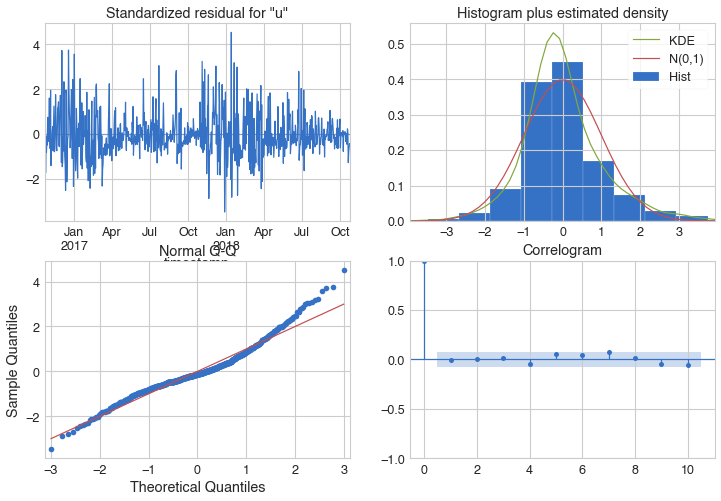

In [74]:
results.plot_diagnostics(figsize=(12,8));

In [75]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  usage   No. Observations:                  733
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -2251.485
Date:                Sun, 06 Mar 2022   AIC                           4508.970
Time:                        19:38:21   BIC                           4522.757
Sample:                    10-22-2016   HQIC                          4514.288
                         - 10-24-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3366      0.031     10.703      0.000       0.275       0.398
ma.L1         -0.9034      0.015    -58.930      0.000      -0.933      -0.873
sigma2        27.4463      1.059     25.909      0.000      25.370      29.523
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               160.13
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               0.52   Skew:                             0.68
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""